In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Optional: visualize or inspect
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("final_processed_dataset.csv")
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head(0)


Loaded dataset with 558 rows and 46 columns.


,ZIP,Metro,CountyName,StateSizeRank,FinalZHVI,FinalZScore,ZHVI_Tier,YoY_2001,YoY_2002,YoY_2003,...,Pct_Bachelors_Or_Higher,Unemployment_Rate,Pct_Below_Poverty,Pct_No_Vehicle,Pct_One_Person_HH,Pct_4plus_HH,Pct_Age_0_17,Pct_Age_18_34,Pct_Age_65plus,YoY_2025


In [2]:
# copy dataframe for modeling
df_model = df.copy()

# drop ZIP (just an ID)
df_model.drop(columns=["ZIP"], inplace=True)

# drop rows where target is missing
df_model = df_model[df_model["YoY_2025"].notna()]

# encode ZHVI_Tier as ordinal
zhvi_tier_mapping = {
    "very low": 0,
    "low": 1,
    "mid": 2,
    "high": 3,
    "very high": 4
}
df_model["ZHVI_Tier"] = df_model["ZHVI_Tier"].map(zhvi_tier_mapping)

# group rare categories in City/Metro/CountyName to 'Other'
def group_rare(series, min_count=2):
    counts = series.value_counts()
    return series.apply(lambda x: x if counts[x] >= min_count else "Other")

df_model["Metro"] = group_rare(df_model["Metro"])
df_model["CountyName"] = group_rare(df_model["CountyName"])

# one-hot encode location columns
df_model = pd.get_dummies(df_model, columns=["Metro", "CountyName"], drop_first=True)


In [3]:
# drop YoY columns before 2017
yoy_cols_to_drop = [col for col in df_model.columns if col.startswith("YoY_") and int(col.split("_")[1]) < 2017]
df_model.drop(columns=yoy_cols_to_drop, inplace=True)

# separate target from features
y = df_model["YoY_2025"]
X = df_model.drop(columns=["YoY_2025"])

# drop rows with missing values
rows_before = X.shape[0]
X = X.dropna()
y = y.loc[X.index]  # keep target in sync
print(f"✅ Dropped {rows_before - X.shape[0]} rows with missing values")
X.head(0)


✅ Dropped 51 rows with missing values


,StateSizeRank,FinalZHVI,FinalZScore,ZHVI_Tier,YoY_2017,YoY_2018,YoY_2019,YoY_2020,YoY_2021,YoY_2022,...,CountyName_Walker County,CountyName_Walton County,CountyName_Ware County,CountyName_Washington County,CountyName_Wayne County,CountyName_Wheeler County,CountyName_Whitfield County,CountyName_Wilkes County,CountyName_Wilkinson County,CountyName_Worth County


In [4]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# scale features (especially for similarity/error-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data split and scaled. Ready for feature selection and modeling.")


✅ Data split and scaled. Ready for feature selection and modeling.


In [5]:
# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# f_regression (linear relationships)
selector_f = SelectKBest(score_func=f_regression, k=21)
X_train_f = selector_f.fit_transform(X_train_scaled, y_train)
X_test_f = selector_f.transform(X_test_scaled)
selected_features_f = X.columns[selector_f.get_support()]
print("Top 21 features (f_regression):")
print(selected_features_f.tolist())

# mutual_info_regression (nonlinear relationships)
selector_mi = SelectKBest(score_func=mutual_info_regression, k=21)
X_train_mi = selector_mi.fit_transform(X_train_scaled, y_train)
X_test_mi = selector_mi.transform(X_test_scaled)
selected_features_mi = X.columns[selector_mi.get_support()]
print("\nTop 21 features (mutual_info_regression):")
print(selected_features_mi.tolist())

# optional: view overlap between methods
shared_features = set(selected_features_f) & set(selected_features_mi)
print(f"\nShared features between both methods ({len(shared_features)}):")
print(sorted(shared_features))


Top 21 features (f_regression):
['StateSizeRank', 'YoY_2017', 'YoY_2018', 'YoY_2021', 'YoY_2023', 'YoYGrowthVolatility', 'Pct_Renter_Occupied', 'Pct_Bachelors_Or_Higher', 'Pct_No_Vehicle', 'Pct_One_Person_HH', 'Pct_4plus_HH', 'Metro_Atlanta-Sandy Springs-Alpharetta, GA', 'Metro_Eufaula, AL-GA', 'Metro_Statesboro, GA', 'CountyName_Clayton County', 'CountyName_Dekalb County', 'CountyName_Emanuel County', 'CountyName_Fulton County', 'CountyName_Henry County', 'CountyName_Tattnall County', 'CountyName_Wheeler County']

Top 21 features (mutual_info_regression):
['StateSizeRank', 'FinalZHVI', 'FinalZScore', 'YoY_2017', 'YoY_2018', 'YoY_2019', 'YoY_2020', 'YoY_2021', 'YoY_2022', 'YoY_2023', 'YoY_2024', 'AvgYoYGrowth', 'YoYGrowthVolatility', 'NegativeGrowthYears', 'Pct_Renter_Occupied', 'Pct_Below_Poverty', 'Pct_No_Vehicle', 'Pct_One_Person_HH', 'Pct_4plus_HH', 'Metro_Atlanta-Sandy Springs-Alpharetta, GA', 'CountyName_Fulton County']

Shared features between both methods (12):
['CountyName_Ful

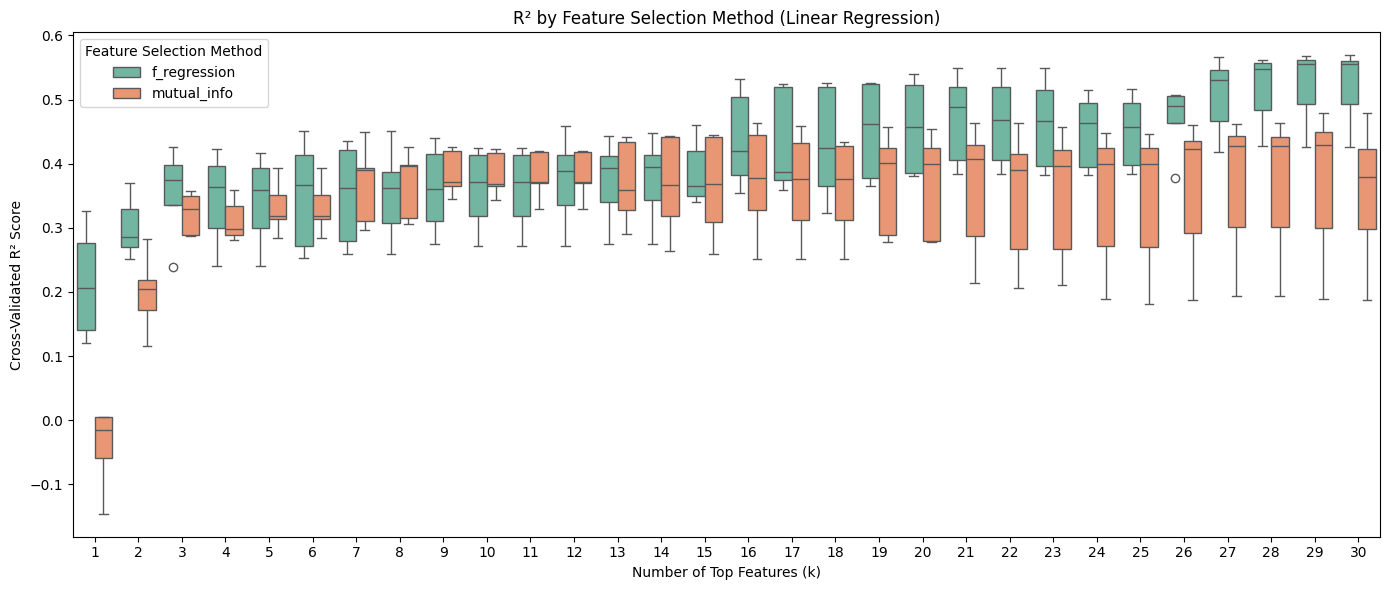

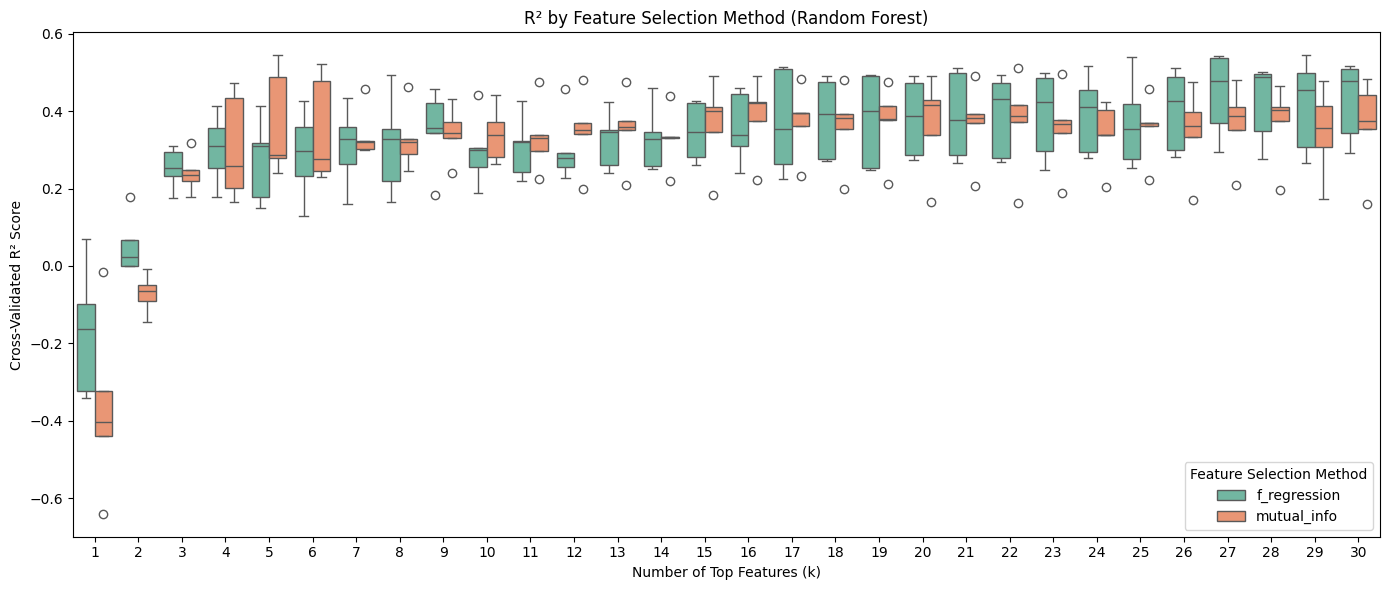

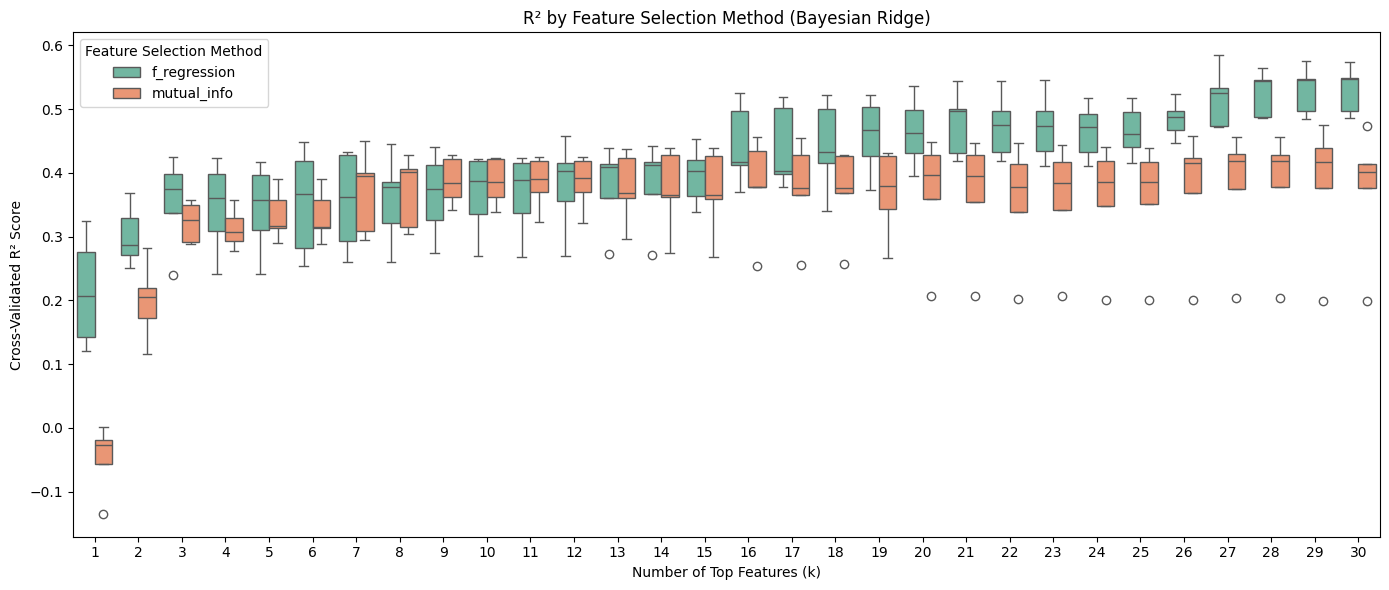

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# settings
max_k = 30
k_range = range(1, max_k + 1)

# model dictionary (no KNN, now using Bayesian Ridge instead)
models = {
    "Linear Regression": LinearRegression,
    "Random Forest": RandomForestRegressor,
    "Bayesian Ridge": BayesianRidge
}

# loop through models
for model_name, model_class in models.items():
    plot_data = []

    for k in range(1, max_k + 1):
        # f_regression
        sel_f = SelectKBest(score_func=f_regression, k=k)
        X_k_f = sel_f.fit_transform(X_train_scaled, y_train)
        model = model_class()
        scores = cross_val_score(model, X_k_f, y_train, cv=5, scoring="r2")
        for score in scores:
            plot_data.append({
                "R²": score, "k": k,
                "Method": "f_regression"
            })

        # mutual_info
        sel_mi = SelectKBest(score_func=mutual_info_regression, k=k)
        X_k_mi = sel_mi.fit_transform(X_train_scaled, y_train)
        model = model_class()
        scores = cross_val_score(model, X_k_mi, y_train, cv=5, scoring="r2")
        for score in scores:
            plot_data.append({
                "R²": score, "k": k,
                "Method": "mutual_info"
            })

    # create DataFrame and plot
    plot_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=plot_df, x="k", y="R²", hue="Method", palette="Set2")
    plt.title(f"R² by Feature Selection Method ({model_name})")
    plt.xlabel("Number of Top Features (k)")
    plt.ylabel("Cross-Validated R² Score")
    plt.legend(title="Feature Selection Method")
    plt.tight_layout()
    plt.show()
